In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.metrics import roc_auc_score
import os
import re
from glob import glob
import time


In [2]:
def set_datetime_as_index(df) :
    df [ 'datetime' ] = pd.to_datetime ( df [ 'datetime' ] )
    df = df.set_index ( 'datetime' )
    df.index.name = 'datetime'
    return df

def set_rhr(df_hr, df_steps):
    df_hr = set_datetime_as_index(df_hr)
    df_steps = set_datetime_as_index(df_steps)

    df = pd.merge(df_hr, df_steps, left_index=True, right_index=True)
    df = df.resample('1min').mean()
    df = df.dropna()

    df['steps_window_12'] = df['steps'].rolling(12).sum()
    df = df.loc[(df['steps_window_12'] == 0)]

    return df

def pre_processing(df):
    # smooth data
    df_nonas = df.dropna()
    df1_rom = df_nonas.rolling(400).mean()
    # resample
    df1_resmp = df1_rom.resample('12H').mean()
    df2 = df1_resmp.drop(['steps'], axis=1)
    df2 = df2.dropna()
    print("preprocess ok")
    return df2

def seasonality_correction(resting_heart_rate, steps):
    """
    This function takes output pre-processing and applies seasonality correction
    """
    sdHR = resting_heart_rate[['heartrate']]
    sdSteps = resting_heart_rate[['steps_window_12']]
    sdHR_decomposition = seasonal_decompose(sdHR, model='additive', period = 14)
   # result.plot()
   # pyplot.show()
    sdSteps_decomposition = seasonal_decompose(sdSteps, model='additive', period = 14)
    sdHR_decomp = pd.DataFrame(sdHR_decomposition.resid + sdHR_decomposition.trend)
    sdHR_decomp.rename(columns={sdHR_decomp.columns[0]:'heartrate'}, inplace=True)
    sdSteps_decomp = pd.DataFrame(sdSteps_decomposition.resid + sdSteps_decomposition.trend)
    sdSteps_decomp.rename(columns={sdSteps_decomp.columns[0]:'steps_window_12'}, inplace=True)
    frames = [sdHR_decomp, sdSteps_decomp]
    data = pd.concat(frames, axis=1)
    
    return data

In [94]:
#Lendo a pasta com os arquivos e associando cada arquivo de hr com um de steps em um dicionario
dicHrSteps = {}
folder = glob('./COVID-19-Wearables/*')
folder = sorted(folder)
#print(folder)
j = 0
for i in range((len(folder)//2)):
    dicHrSteps[folder[j]] = folder[j+1]
    j+=2
#print("-----"*10)
#print(dicHrSteps)"""

In [ ]:
#criação de RHRs de cada indivíduo
i=1
dfGeral = pd.DataFrame()
for chave, valor in dicHrSteps.items():
    nome = str(chave)
    nome = nome.replace("./COVID-19-Wearables\\", "")
    nome = nome.replace("_hr.csv", "")
    dfHr = pd.read_csv(chave)
    dfSteps = pd.read_csv(valor)
    dfRhr = set_rhr(dfHr, dfSteps)
    dfRhr = pre_processing(dfRhr)
    dfRhr = dfRhr.drop(columns=['steps_window_12'])
    dfRhr = dfRhr.dropna()
    print(nome," ---- ",i)
    dfRhr.to_csv(nome+'_RHR'+'.csv', index=True)
    i+=1
    
print("OK")

A próxima celula corrige a data dos arquivos rhrs e faz utiliza o modelo Isolation Forest

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              datetime  heartrate    scores  anomaly_score Outliers
4  2023-11-04 12:00:00  83.601250 -0.031782             -1      yes
5  2023-11-05 00:00:00  85.440395 -0.016632             -1      yes
54 2023-12-10 00:00:00  85.887790 -0.057423             -1      yes
55 2023-12-11 00:00:00  86.542000 -0.073313             -1      yes
56 2023-12-11 12:00:00  86.777414 -0.136253             -1      yes
57 2023-12-12 00:00:00  86.443517 -0.075894             -1      yes
58 2023-12-12 12:00:00  84.356944 -0.013017             -1      yes
66 2023-12-16 12:00:00  73.570357 -0.079843             -1      yes
67 2023-12-17 00:00:00  74.024133 -0.075473             -1      yes
68 2023-12-18 00:00:00  73.467773 -0.067647             -1      yes
69 2023-12-18 12:00:00  73.476818 -0.057606             -1      yes
70 2023-12-19 00:00:00  74.517075 -0.005489             -1      yes
76 2023-12-22 00:00:00  78.704868 -0.007406             -1      yes


C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


               datetime  heartrate    scores  anomaly_score Outliers
2   2023-08-21 00:00:00  71.527447 -0.022854             -1      yes
3   2023-08-21 12:00:00  71.946429 -0.071087             -1      yes
4   2023-08-22 00:00:00  71.726027 -0.037319             -1      yes
5   2023-08-22 12:00:00  72.165078 -0.160174             -1      yes
6   2023-08-23 00:00:00  71.716992 -0.034723             -1      yes
7   2023-08-23 12:00:00  71.916136 -0.069712             -1      yes
8   2023-08-24 00:00:00  71.085500 -0.055988             -1      yes
9   2023-08-25 00:00:00  70.494276 -0.003136             -1      yes
74  2023-09-27 00:00:00  59.392679 -0.148793             -1      yes
75  2023-09-27 12:00:00  59.757875 -0.059329             -1      yes
76  2023-09-28 00:00:00  60.506118 -0.005924             -1      yes
82  2023-10-01 00:00:00  59.501146 -0.102270             -1      yes
83  2023-10-01 12:00:00  59.902857 -0.028443             -1      yes
84  2023-10-02 00:00:00  59.980293

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


               datetime  heartrate    scores  anomaly_score Outliers
1   2028-04-27 00:00:00  76.126319 -0.015662             -1      yes
2   2028-04-27 12:00:00  75.861190 -0.009496             -1      yes
3   2028-04-28 00:00:00  76.278500 -0.001783             -1      yes
4   2028-04-28 12:00:00  76.609514 -0.000171             -1      yes
5   2028-04-29 00:00:00  75.789509 -0.012426             -1      yes
8   2028-04-30 12:00:00  75.282500 -0.022604             -1      yes
107 2028-06-21 12:00:00  77.572077 -0.120764             -1      yes
108 2028-06-22 00:00:00  79.204574 -0.125557             -1      yes
109 2028-06-22 12:00:00  81.488880 -0.214686             -1      yes
110 2028-06-23 00:00:00  80.846301 -0.190533             -1      yes
111 2028-06-23 12:00:00  78.966532 -0.115541             -1      yes
112 2028-06-24 00:00:00  76.656284 -0.011983             -1      yes
120 2028-06-28 00:00:00  67.004671 -0.003932             -1      yes
126 2028-07-01 00:00:00  65.447500

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              datetime  heartrate    scores  anomaly_score Outliers
2  2027-08-04 00:00:00  74.320926 -0.008004             -1      yes
3  2027-08-04 12:00:00  73.601875 -0.005141             -1      yes
7  2027-08-06 12:00:00  75.052857 -0.011758             -1      yes
8  2027-08-07 00:00:00  76.719271 -0.073567             -1      yes
9  2027-08-07 12:00:00  78.381522 -0.123336             -1      yes
10 2027-08-08 00:00:00  79.044340 -0.194704             -1      yes
11 2027-08-08 12:00:00  78.184138 -0.118250             -1      yes
12 2027-08-09 00:00:00  77.058793 -0.093972             -1      yes
13 2027-08-09 12:00:00  76.134800 -0.072698             -1      yes
49 2027-08-27 12:00:00  63.989655 -0.035728             -1      yes
50 2027-08-28 00:00:00  63.658773 -0.003825             -1      yes
51 2027-08-28 12:00:00  63.072000 -0.011024             -1      yes
52 2027-08-29 00:00:00  63.142442 -0.000104             -1      yes
54 2027-08-30 00:00:00  63.291603 -0.001048     

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              datetime  heartrate    scores  anomaly_score Outliers
47 2023-03-23 00:00:00  60.239386 -0.094636             -1      yes
80 2023-04-11 00:00:00  66.869828 -0.000346             -1      yes
82 2023-04-12 00:00:00  67.633814 -0.025703             -1      yes
83 2023-04-12 12:00:00  68.375341 -0.048467             -1      yes
84 2023-04-13 00:00:00  68.965943 -0.073157             -1      yes
85 2023-04-13 12:00:00  70.704745 -0.017465             -1      yes
86 2023-04-14 00:00:00  72.140213 -0.018179             -1      yes
87 2023-04-14 12:00:00  72.502500 -0.043576             -1      yes
89 2023-04-15 12:00:00  71.412065 -0.001010             -1      yes
90 2023-04-16 00:00:00  71.076300 -0.013747             -1      yes
91 2023-04-16 12:00:00  70.777500 -0.005133             -1      yes
92 2023-04-17 00:00:00  71.523415 -0.009713             -1      yes
93 2023-04-17 12:00:00  73.012563 -0.121244             -1      yes
94 2023-04-18 00:00:00  72.751667 -0.065055     

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


               datetime  heartrate    scores  anomaly_score Outliers
6   2029-09-11 12:00:00  61.176250 -0.009999             -1      yes
7   2029-09-12 00:00:00  61.139015 -0.038154             -1      yes
8   2029-09-12 12:00:00  61.081500 -0.118335             -1      yes
9   2029-09-13 00:00:00  61.230000 -0.014695             -1      yes
32  2029-09-25 12:00:00  61.395000 -0.009451             -1      yes
62  2029-10-11 00:00:00  61.161225 -0.008355             -1      yes
100 2029-11-02 00:00:00  69.421358 -0.104873             -1      yes
101 2029-11-02 12:00:00  70.623676 -0.047827             -1      yes
102 2029-11-03 00:00:00  70.306645 -0.096351             -1      yes
103 2029-11-03 12:00:00  70.459250 -0.028360             -1      yes
104 2029-11-04 00:00:00  70.590735 -0.028798             -1      yes
105 2029-11-04 12:00:00  70.561818 -0.032551             -1      yes
106 2029-11-05 00:00:00  70.779577 -0.110944             -1      yes
107 2029-11-05 12:00:00  71.000833

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              datetime  heartrate    scores  anomaly_score Outliers
3  2025-08-23 00:00:00  59.876351 -0.047889             -1      yes
4  2025-08-23 12:00:00  59.623900 -0.009898             -1      yes
5  2025-08-24 00:00:00  59.257368 -0.025547             -1      yes
7  2025-08-25 00:00:00  58.425938 -0.042227             -1      yes
10 2025-08-27 00:00:00  58.377965 -0.083075             -1      yes
12 2025-08-28 00:00:00  58.786047 -0.000007             -1      yes
14 2025-08-29 00:00:00  59.131633 -0.019449             -1      yes
15 2025-08-29 12:00:00  59.513750 -0.021347             -1      yes
16 2025-08-30 00:00:00  59.712723 -0.014453             -1      yes
17 2025-08-30 12:00:00  61.026000 -0.056106             -1      yes
37 2025-09-10 12:00:00  69.907500 -0.014871             -1      yes
40 2025-09-12 00:00:00  69.953846 -0.026941             -1      yes
41 2025-09-12 12:00:00  70.600938 -0.086271             -1      yes
42 2025-09-13 00:00:00  70.683400 -0.076772     

C:\Users\luizf\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


              datetime  heartrate    scores  anomaly_score Outliers
22 2024-07-11 12:00:00  71.709259 -0.000251             -1      yes
61 2024-07-31 12:00:00  67.854615 -0.002479             -1      yes
63 2024-08-01 12:00:00  73.720741 -0.016157             -1      yes
65 2024-08-02 12:00:00  80.008241 -0.021878             -1      yes
66 2024-08-03 00:00:00  82.040794 -0.119821             -1      yes
67 2024-08-03 12:00:00  82.326024 -0.148139             -1      yes
68 2024-08-04 00:00:00  80.687373 -0.077633             -1      yes
69 2024-08-04 12:00:00  81.454652 -0.115985             -1      yes
70 2024-08-05 00:00:00  79.532213 -0.027557             -1      yes
71 2024-08-05 12:00:00  79.780921 -0.008474             -1      yes
72 2024-08-06 00:00:00  78.833413 -0.048118             -1      yes
75 2024-08-07 12:00:00  77.981667 -0.056722             -1      yes
77 2024-08-08 12:00:00  76.056500 -0.003898             -1      yes
79 2024-08-09 12:00:00  75.622784 -0.001995     

<Figure size 432x288 with 0 Axes>

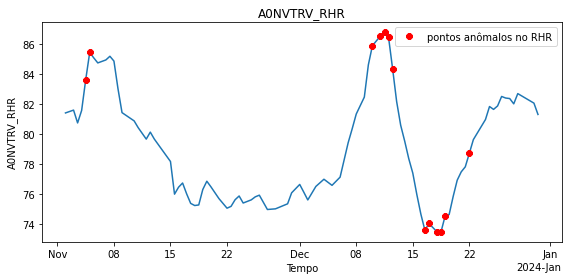

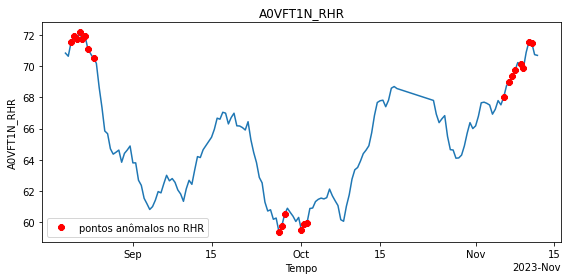

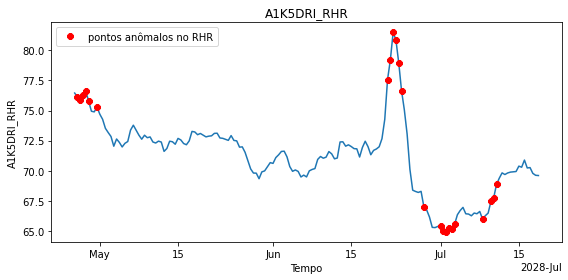

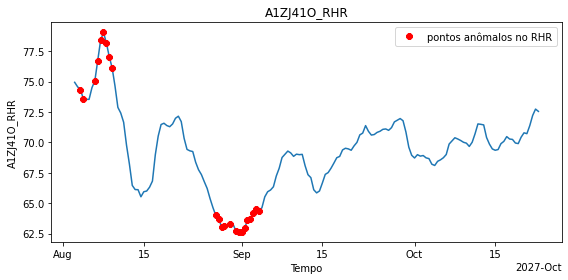

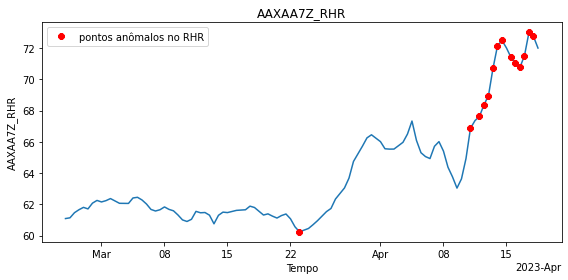

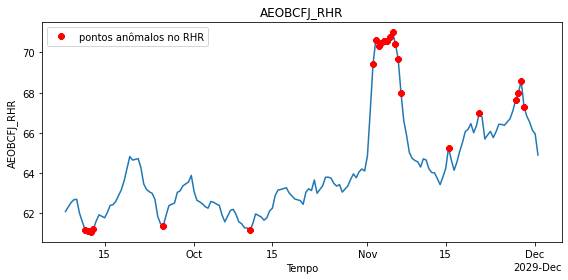

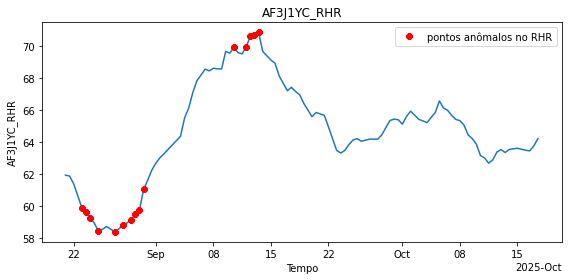

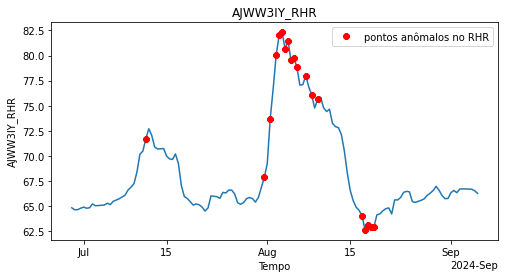

In [40]:

from datetime import datetime
import matplotlib.dates as mdates
import seaborn as sns
from sklearn.ensemble import IsolationForest
import matplotlib
import matplotlib.colors as mcolors
#matplotlib.use('Agg') #serve para salvar as figuras quando dá um bug que são salvas vazias
import matplotlib.pyplot as plt
#diminuir contaminação para alguns
folder = glob('./RHR/POS/POSUSED/*')
folder = sorted(folder)

#testando com vários RHRs de uma só vez
for i in folder:  
    
    csvRhr = i
    data = pd.read_csv(csvRhr)
    #corrige o formato da data
    data.head(10)
    data['datetime'] = pd.to_datetime(data['datetime'], format="%Y-%m-%d %H:%M:%S")
    nome = csvRhr.split('\\')
    nome1 = nome[1].split('.')
    nome2 = nome1[0]
    
    #treina o modelo
    random_state = 42
    model=IsolationForest(n_estimators=100,max_samples="auto",contamination=0.14,random_state=random_state)
    model.fit(data[['heartrate']])
    #print(model.get_params())
    
    #add as informações obtidas ao dataframe
    data['scores'] = model.decision_function(data[['heartrate']])
    data['anomaly_score'] = model.predict(data[['heartrate']])
    data[data['anomaly_score']==-1].head()
    data['Outliers']=pd.Series(model.predict(data[['heartrate']])).apply(lambda x: 'yes' if (x == -1) else 'no' )

    ax = data[data['anomaly_score']==-1]
    ax = ax.index.values
    data[data['anomaly_score']==-1]
    markers_on = list(ax) 
    print(data[data['anomaly_score']==-1])
  
    #plota as figuras 
    plt.tight_layout()
    plt.figure(figsize=(8,4))
    plt.title(nome2)
    plt.plot((data['datetime']), data['heartrate'])
    #marca os pontos com anomalia no gráfico
    plt.plot(data['datetime'], data['heartrate'],'r8',markevery=markers_on,label='pontos anômalos no RHR')
    plt.xlabel("Tempo", rotation=0)
    plt.ylabel(nome2, rotation=90)
    plt.legend()
    #corrige o formato das datas nos gráficos
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    plt.gca().xaxis.set_major_formatter(formatter) # apply the format to the desired axis
    #plt.show()
    #plt.savefig(nome2+'.svg', format='svg')
    

In [261]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   datetime       113 non-null    datetime64[ns]
 1   heartrate      113 non-null    float64       
 2   scores         113 non-null    float64       
 3   anomaly_score  113 non-null    int32         
 4   Outliers       113 non-null    object        
dtypes: datetime64[ns](1), float64(2), int32(1), object(1)
memory usage: 4.1+ KB


In [314]:
#dados com anomalia
data[data['anomaly_score']==-1]

,datetime,heartrate,scores,anomaly_score,Outliers
29,2024-11-27 12:00:00,60.959375,-0.049022,-1,yes
35,2024-12-01 12:00:00,60.919000,-0.019209,-1,yes
39,2024-12-04 00:00:00,57.540733,-0.009479,-1,yes
40,2024-12-05 00:00:00,56.138510,-0.024041,-1,yes
41,2024-12-05 12:00:00,55.859500,-0.030256,-1,yes
44,2024-12-07 00:00:00,55.153261,-0.039659,-1,yes
45,2024-12-07 12:00:00,54.879167,-0.033043,-1,yes
46,2024-12-08 00:00:00,54.690976,-0.060809,-1,yes
47,2024-12-08 12:00:00,54.443125,-0.139191,-1,yes
48,2024-12-09 00:00:00,54.809894,-0.027911,-1,yes
